In [1]:
import os
import random
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import export_text
from joblib import dump, load

# Data Generation

In [2]:
columns = ['Invested Amount', 'Successful Attacks', 'Failed Attacks', 'Business Value', 'Number of Employees', 'Employee Training', 'Known Vulnerabilities', 'External Advisor', 'Risk']
features = columns[:-1]
LEVELS = ["LOW", "MEDIUM", "HIGH"]
prediction_result_mapping = {0: "LOW", 1: "MEDIUM", 2: "HIGH"}

In [3]:
def generate_data(nr_entries = 1000, min_empl = 30, max_empl = 90000, min_nr_attacks = 0, nr_attacks = 50, 
                  avg_business_value = 5000000, std_business_value = 50000, max_invested_perc = 0.3, max_nr_vulnerabilities = 10):
    df = pd.DataFrame(columns=columns)
    for i in range(0, nr_entries):
        nr_employees = random.randint(min_empl, max_empl)
        employees_training = random.choice(LEVELS)
        failed_attack = random.randrange(nr_attacks)
        succ_attack = random.randrange(nr_attacks)
        business_value = int(numpy.random.normal(loc=avg_business_value, scale=std_business_value))
        invested_perc = random.uniform(0, max_invested_perc)
        invested_amount = int(invested_perc * business_value)
        known_vulnerabilities = random.randrange(max_nr_vulnerabilities)
        external_adv = "NO" if (i % 2) == 0 else "YES"

        # Risk is computed based on the other parameters and is then categorized using 'get_categorized_risk'
        computed_risk = invested_perc - (succ_attack / nr_attacks) + (nr_employees / max_empl) * LEVELS.index(employees_training) - (known_vulnerabilities / max_nr_vulnerabilities) + (i % 2) / 3
        
        df.loc[i] = [invested_amount, succ_attack, failed_attack, business_value, nr_employees, employees_training, known_vulnerabilities, external_adv, get_categorized_risk(computed_risk)]
    return df

def get_categorized_risk(weighted_risk, low_medium_boundary = 1.0, medium_high_boundary = 0.0):
  if weighted_risk >= low_medium_boundary:
      return "LOW"
  elif weighted_risk >= medium_high_boundary and weighted_risk < low_medium_boundary:
      return "MEDIUM"
  else:
      return "HIGH"

In [4]:
data = generate_data(nr_entries = 5000)

In [5]:
data.head()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
0,416183,27,41,4930658,353,HIGH,6,NO,HIGH
1,1395783,39,20,5014496,28852,MEDIUM,4,YES,HIGH
2,1213920,7,32,5006201,75252,MEDIUM,0,NO,MEDIUM
3,912599,3,6,4952275,38527,HIGH,5,YES,MEDIUM
4,659114,30,20,5015398,87347,LOW,6,NO,HIGH


In [6]:
data.describe()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
count,5000,5000,5000,5000,5000,5000,5000,5000,5000
unique,4994,50,50,4934,4876,3,10,2,3
top,79472,20,40,5035022,27902,LOW,7,NO,HIGH
freq,2,119,134,2,3,1698,523,2500,3003


## Data Export as .csv

In [7]:
# data.to_csv('train_test_dataset.csv')

# Data Processing

## Categorization Step

In [8]:
levels_mapping = { 'LOW': 0, 'MEDIUM': 1, 'HIGH': 2 }
advisor_mapping = { 'NO': 0, 'YES': 1 }

data = data.replace({'Employee Training': levels_mapping, 'Risk': levels_mapping, 'External Advisor': advisor_mapping})

In [9]:
data.head()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
0,416183,27,41,4930658,353,2,6,0,2
1,1395783,39,20,5014496,28852,1,4,1,2
2,1213920,7,32,5006201,75252,1,0,0,1
3,912599,3,6,4952275,38527,2,5,1,1
4,659114,30,20,5015398,87347,0,6,0,2


## Normalization Step

In [10]:
normalized_data = data[features].apply(lambda x: ( (x - x.min()) / (x.max() - x.min())))
normalized_data.head()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor
0,0.27342,0.55102,0.836735,0.314335,0.00342412,1.0,0.666667,0.0
1,0.917228,0.795918,0.408163,0.540121,0.320256,0.5,0.444444,1.0
2,0.797705,0.142857,0.653061,0.517781,0.836098,0.5,0,0.0
3,0.599672,0.0612245,0.122449,0.372552,0.427815,1.0,0.555556,1.0
4,0.433078,0.612245,0.408163,0.54255,0.970561,0.0,0.666667,0.0


# Deep Neural Network Classifier

In [11]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [12]:
# Define the training inputs
def get_train_inputs():
    x = { feature_name: tf.constant(X_train, dtype=tf.float64)}
    y = tf.constant(y_train, dtype=tf.int32)
    return x, y

# Define the test inputs
def get_test_inputs():
    x = { feature_name: tf.constant(X_test, dtype=tf.float64)}
    y = tf.constant(y_test, dtype=tf.int32)
    return x, y

In [13]:
X_train, X_test, y_train, y_test = train_test_split(normalized_data[features].values, data["Risk"].values, test_size=0.35)

In [14]:
# Specify that all features have real-value data
feature_name = "risk_features"
feature_columns = [tf.feature_column.numeric_column(feature_name, 
                                                    shape=len(features))]

In [15]:
# Build 5 layer DNN with 512, 256, 128, 64, 32 units respectively.
classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                            hidden_units=[512, 256, 128, 64],
                                            n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp11bq_gsa', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Train

In [16]:
classifier.train(input_fn=get_train_inputs, steps=5000)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp11bq_gsa/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.0841851, step = 0
INFO:tensorflow:global_step/sec: 14.1689
INFO:tensorflow:loss = 0.98145723, step = 100 (7.059 sec)
INFO:tensorflow:global_step/sec: 14.1692
INFO:tensorflow:loss = 0.91362655, step = 200 (7.060 sec)
INFO:tensorflow:global_step/s

## Evaluate

In [17]:
accuracy_score = classifier.evaluate(input_fn=get_test_inputs, steps=100)["accuracy"]

print('Accuracy: {0:.2%}'.format(accuracy_score))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-02-12T16:55:43Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp11bq_gsa/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Inference Time : 2.61630s
INFO:tensorflow:Finished evaluation at 2021-02-12-16:55:46
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.91485715, average_loss = 0.21978666, global_step = 5000, loss = 0.21978694
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /

## Export

In [18]:
# feature_spec = {'risk_features': tf.io.FixedLenFeature(shape=len(features), dtype=tf.float32)}

# serving_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)

# classifier.export_saved_model(export_dir_base='./model/export', serving_input_receiver_fn=serving_fn)

## Prediction

### Data Preparation

In [19]:
def get_data_for_prediction():
  return { feature_name: tf.constant(normalized_prediction_df, dtype=tf.float64)}

# Create DataFrame from data to be predicted
prediction_df = pd.DataFrame([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]], columns=features)

# Normalize using the initial dataframe -> bring the data for the prediction to the same scale
normalized_prediction_df = prediction_df[features]
for feature in features:
    normalized_prediction_df[feature] = normalized_prediction_df[feature].apply(lambda x: ( (x - data[feature].min()) / (data[feature].max() - data[feature].min())))

normalized_prediction_df

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor
0,0.707793,0.163265,0.591837,0.36049,0.642957,0.5,0.666667,0.0


### Result

In [20]:
for pred in classifier.predict(input_fn=get_data_for_prediction):
  print("\n")
  print("Predicted RISK is: " + prediction_result_mapping[pred['class_ids'][0]])
  break

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp11bq_gsa/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Predicted RISK is: MEDIUM


# Decision Tree Classifier

In [21]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score

In [22]:
# Data here is not normalized
X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["Risk"].values, random_state=0)

## Train

In [23]:
dtree_model = DecisionTreeClassifier().fit(X_train, y_train) 

## Evaluate

In [24]:
accuracy = dtree_model.score(X_test, y_test) 

print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 87.92%


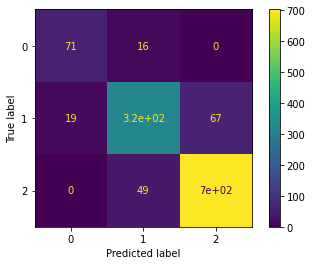

In [25]:
plot_confusion_matrix(dtree_model, X_test, y_test)  
plt.show()

## Export

In [26]:
#r = export_text(dtree_model, feature_names=features)
#print(r)

dump(dtree_model, 'Tree_classifier.joblib') 

['Tree_classifier.joblib']

## Prediction

In [27]:
# Create DataFrame from data to be predicted
prediction_df = pd.DataFrame([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]], columns=features)
prediction_df

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor
0,1077113,8,29,4947796,57879,1,6,0


In [28]:
predicted_risk = dtree_model.predict(prediction_df)[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: MEDIUM


# Support Vector Machine (SVM) classifier

In [29]:
from sklearn.svm import LinearSVC, SVC 

In [30]:
# Data here is normalized
X_train, X_test, y_train, y_test = train_test_split(normalized_data[features].values, data["Risk"].values)

## Train

In [31]:
# Linear
#svm_model = LinearSVC().fit(X_train, y_train)

svm_model = SVC(kernel='poly').fit(X_train, y_train)

## Evaluate

In [32]:
accuracy = svm_model.score(X_test, y_test) 

print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 97.04%


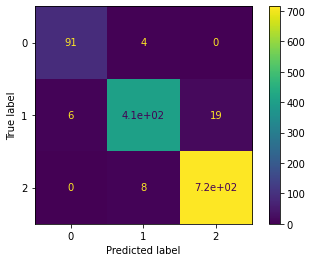

In [33]:
plot_confusion_matrix(svm_model, X_test, y_test)  
plt.show()

## Export

In [34]:
dump(svm_model, 'SVM_classifier.joblib') 

## Prediction

In [35]:
predicted_risk = svm_model.predict(normalized_prediction_df)[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: MEDIUM


# K-nearest Neighbours Classifier

In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
# Data here is not normalized
X_train, X_test, y_train, y_test = train_test_split(normalized_data[features].values, data["Risk"].values)

## Train

In [38]:
knn = KNeighborsClassifier(n_neighbors = 17).fit(X_train, y_train) 

## Evaluate

In [39]:
accuracy = knn.score(X_test, y_test) 
print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 90.96%


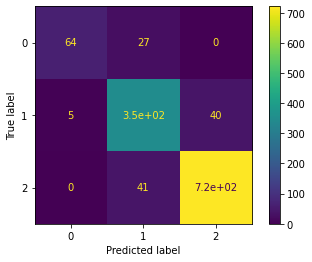

In [40]:
plot_confusion_matrix(knn, X_test, y_test)  
plt.show()

## Export

In [41]:
dump(knn, 'KNN_classifier.joblib') 

['KNN_classifier.joblib']

## Prediction

In [42]:
predicted_risk = knn.predict(normalized_prediction_df)[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: MEDIUM


# Multilayer Perceptron (MLP) using Backpropagation

In [43]:
from sklearn.neural_network import MLPClassifier

In [44]:
# Data here is normalized
X_train, X_test, y_train, y_test = train_test_split(normalized_data[features].values, data["Risk"].values)

In [134]:
clf = MLPClassifier(activation='tanh', solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), max_iter=10000)

## Train

In [138]:
clf.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

## Evaluate

In [139]:
accuracy = clf.score(X_test, y_test) 

print('Accuracy: {0:.2%}'.format(accuracy))

# lbfgs
# identity -> 90.72%
# logistic -> 98.88%
# tanh -> 99.68%
# relu -> 62.08%


# sgd
# identity -> 90.48%
# logistic -> 62.08%
# tanh -> 98.24%
# relu -> 62.08%

# adam
# identity -> 90.88%
# logistic -> 98.48%
# tanh -> 99.04%
# relu -> 98.88%

Accuracy: 99.68%


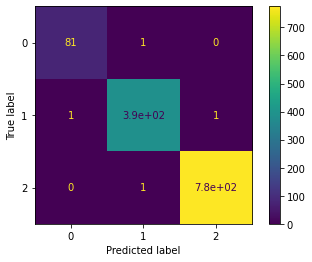

In [140]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

## Export

In [49]:
dump(clf, 'MLP_classifier.joblib')

## Prediction

In [81]:
predicted_risk = knn.predict(normalized_prediction_df)[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: MEDIUM
